In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


df =pd.read_csv('train.csv')

### UNCOMMENT THIS PART TO USE THE FEATURE ENGINEERING
df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']

# Create 'total_charges' feature
df['total_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

# Create 'total_minutes' feature
df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
df = df.drop(['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1)

# Delete contributing features for 'total_charges'
df = df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

# Delete contributing features for 'total_minutes'
df = df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes'], axis=1)


df.drop(['state','area_code'], axis=1, inplace=True)
# df.drop(['state', 'area_code', 'account_length'], axis=1, inplace=True)



###################

###ONE HOT ENCODING


# df = pd.get_dummies(df, columns=['area_code'])


### MOVING THE Y VARIABLE TO THE END
churn = df['churn']
df = df.drop('churn', axis=1)
df['churn'] = churn


data=np.array(df)


data[data=='no']=0
data[data=='yes']=1
data[data==False]=0
data[data==True]=1
print(data[0])
X=data[:,:-1]
y=data[:,-1]



### SPLITTING THE DATA INTO TRAIN, VALIDATION AND TEST SETS

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

###DATA NORMALIZATION
def normalize(X):
    X = X.astype(float)
    X=(X-X.mean(axis=0))/X.std(axis=0)
    return X

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)


#SMOTE, oversampling the minority class (will read more about this later)
X_train_oversampled_smote = []
labels_train_oversampled_smote = []
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])
for _ in range(X_train.shape[0]):
    p = np.random.random()
    #sample from majority class
    if p < 0.5:
        X_train_oversampled_smote.append(X_train[np.random.choice(indices_0)])
        labels_train_oversampled_smote.append(0)
    #sample from minority class
    else:
        #get two random samples from minority class
        minority_samp_1 = X_train[np.random.choice(indices_1)]
        minority_samp_2 = X_train[np.random.choice(indices_1)]
        
        #get random proportion with which to mix them
        prop = np.random.random()
        
        #generate synthetic sample from minority class
        synthetic_minority_samp = prop*minority_samp_1 + (1-prop)*minority_samp_2
        X_train_oversampled_smote.append(synthetic_minority_samp)
        labels_train_oversampled_smote.append(1)
        
X_train_with_SMOTE = np.array(X_train_oversampled_smote)
y_train_with_SMOTE = np.array(labels_train_oversampled_smote)

X_train_with_SMOTE = X_train_with_SMOTE.astype(np.float32)
y_train_with_SMOTE = y_train_with_SMOTE.astype(np.float32)
y_train_with_SMOTE = y_train_with_SMOTE.reshape(-1,1)



###CONVERT TO APPROPIATE FORMAT
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
y_test = y_test.reshape(-1,1)
####




[107 0 1 26 13.7 3 3.7 1 329 55.540000000000006 611.5 0]


In [2]:


def reLU(z):
    return np.maximum(0,z)
def reLU_derivative(z):
    return z>0
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))


def initialize_parameters(layers):
    W=[]
    b=[]
    for i in range(1,len(layers)):
        W.append(np.random.rand(layers[i-1],layers[i]) - 0.5)
        b.append(np.random.rand(1,layers[i]) - 0.5)
        
        
    return W,b



def my_dense(X,W,b, use_sigmoid=False):
    z=np.matmul(X,W)+b 
    return sigmoid(z) if use_sigmoid else reLU(z)


def forward_propagation(X,W,b):
    A=[]
    prev_A=X
    for i in range(len(W)):
        prev_A=my_dense(prev_A,W[i],b[i], use_sigmoid=(i==len(W)-1))
        A.append(prev_A)
       
    
    return A     
    
def squared_error(y,A):
    return np.sum((y-A)**2)/y.shape[0]

def update_parameters(W,b,dW,db,learning_rate):
    for i in range(len(W)):
        W[i]=W[i]-learning_rate*dW[i]
        b[i]=b[i]-learning_rate*db[i]
        
    return W,b

def train(X_train,y_train,learning_rate,epochs,layers):
    costs=[]
    W,b=initialize_parameters(layers)
    for i in range(epochs):
        A=forward_propagation(X_train,W,b)
        dW,db=back_propagation(X_train,y_train,A,W)
        W,b=update_parameters(W,b,dW,db,learning_rate)
        loss=squared_error(y_train,A[-1])
        costs.append(loss)
        print(f"Epoch {i} : Loss {loss}")
        acc=accuracy(y_train,A[-1])
        print(f"Train Accuracy: {acc}")
   
        if acc == 1:
            break
        
        
        
    return W,b,costs

def back_propagation(X,y,A,W,alpha=0.01):
    dW=[]
    db=[]
    m=y.shape[0]
    dA=(A[-1]-y)

    dZ=dA*sigmoid_derivative(A[-1])
    dC_dW = (A[-2].T.dot(dZ)+alpha * W[-1])/m

    
    dW.append(dC_dW)
    dC_db=np.sum(dZ,axis=0,keepdims=True)/m
    db.append(dC_db)
  
    for i in range(len(W)-2,0,-1):
       
        U=dZ.dot(W[i+1].T)
        V=reLU_derivative(A[i])
        dZ=U*V
        dW.append((A[i-1].T.dot(dZ)+alpha * W[i])/m)
        db.append(np.sum(dZ,axis=0,keepdims=True)/m)
        
    dZ=dZ.dot(W[1].T)*reLU_derivative(A[0])
    dW.append((X.T.dot(dZ)+alpha * W[0])/m)
    db.append(np.sum(dZ,axis=0,keepdims=True)/m)
    return dW[::-1],db[::-1]


def accuracy(y,A,threshold=0.5):
    return np.mean((A>threshold)==y)


In [3]:
layer_list=[[X_train.shape[1],64,64,1]]
lr_list = [0.01]
reg_list = [0.01]
threshold_list = [0.5]
default_epoch = 5000
best_accuracy = 0
best_layer = []
layer_cost = []
avg_accuracy_without_SMOTE = 0
avg_f1_without_SMOTE = 0
avg_accuracy_with_SMOTE = 0
avg_f1_with_SMOTE = 0

from sklearn.metrics import f1_score
for i in range(10):
    for layers in layer_list:
        for lr in lr_list:
            for reg in reg_list:
                for threshold in threshold_list:
                    W,b,costs=train(X_train,y_train,lr,default_epoch,layers)
                    layer_cost.append((layers,costs))
                    A=forward_propagation(X_val,W,b)
                    acc = accuracy(y_val,A[-1],threshold)
                    print(f"Validation Accuracy: {acc}")
                    avg_accuracy_without_SMOTE += acc
                    avg_f1_without_SMOTE += f1_score(y_val, A[-1]>threshold)
                    acc_test = accuracy(y_test,forward_propagation(X_test,W,b)[-1],threshold)
                    print(f"Test Accuracy: {acc_test}")
                    
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_lr = lr
                        best_reg = reg
                        best_threshold = threshold
                        W_best = W
                        b_best = b
                        best_layer = layers
                        

avg_accuracy_without_SMOTE /= 10     
avg_f1_without_SMOTE /= 10         

for i in range(10):
    for layers in layer_list:
        for lr in lr_list:
            for reg in reg_list:
                for threshold in threshold_list:
                    W,b,costs=train(X_train_with_SMOTE,y_train_with_SMOTE,lr,default_epoch,layers)
                    
                    A=forward_propagation(X_val,W,b)
                    acc = accuracy(y_val,A[-1],threshold)
                    print(f"Validation Accuracy: {acc}")
                    avg_accuracy_with_SMOTE += acc
                    avg_f1_with_SMOTE += f1_score(y_val, A[-1]>threshold)
                    acc_test = accuracy(y_test,forward_propagation(X_test,W,b)[-1],threshold)
                    print(f"Test Accuracy: {acc_test}")
                    
                    if acc > best_accuracy:
                        best_accuracy = acc
                        best_lr = lr
                        best_reg = reg
                        best_threshold = threshold
                        W_best = W
                        b_best = b
                        best_layer = layers
                        
                        
avg_accuracy_with_SMOTE /= 10
avg_f1_with_SMOTE /= 10
print(f"Best Accuracy on validation set: {best_accuracy}")    
print(f"Best Learning Rate: {best_lr}")
print(f"Best Regularization: {best_reg}")
print(f"Best Threshold: {best_threshold}")
print(f"Best Layer: {best_layer}")

A_test=forward_propagation(X_test,W_best,b_best)
acc_test = accuracy(y_test,A_test[-1],best_threshold)
print(f"Test Accuracy with W,b: {acc_test}")


import pickle

# Save W and b to a single file
with open('parameters.pkl', 'wb') as f:
    pickle.dump((W_best,b_best ), f)

Epoch 0 : Loss 0.5154097509414367
Train Accuracy: 0.293109243697479
Epoch 1 : Loss 0.5064260423382857
Train Accuracy: 0.30050420168067227
Epoch 2 : Loss 0.49750785203259873
Train Accuracy: 0.30789915966386555
Epoch 3 : Loss 0.4886640588963887
Train Accuracy: 0.31529411764705884
Epoch 4 : Loss 0.4799027967969074
Train Accuracy: 0.32235294117647056
Epoch 5 : Loss 0.471230887975371
Train Accuracy: 0.333781512605042
Epoch 6 : Loss 0.4626605007870134
Train Accuracy: 0.3445378151260504
Epoch 7 : Loss 0.45420052991395005
Train Accuracy: 0.3522689075630252
Epoch 8 : Loss 0.4458550711403926
Train Accuracy: 0.35764705882352943
Epoch 9 : Loss 0.43763258915493963
Train Accuracy: 0.36739495798319327
Epoch 10 : Loss 0.42954261505665586
Train Accuracy: 0.3761344537815126
Epoch 11 : Loss 0.4215876318960617
Train Accuracy: 0.3808403361344538
Epoch 12 : Loss 0.4137720920417393
Train Accuracy: 0.38789915966386557
Epoch 13 : Loss 0.4061025771435254
Train Accuracy: 0.39966386554621847
Epoch 14 : Loss 0.398

In [4]:
print(f"Avg accuracy with SMOTE: {avg_accuracy_with_SMOTE}")
print(f"F1 score with SMOTE: {avg_f1_with_SMOTE}")
print(f"Avg accuracy without SMOTE: {avg_accuracy_without_SMOTE}")
print(f"F1 score without SMOTE: {avg_f1_without_SMOTE}")

0.8259026687598116
0.9161695447409735


In [16]:
import matplotlib.pyplot as plt

# Plot the first average F1 score
plt.subplot(1, 2, 1)
plt.bar(['With SMOTE', 'Without SMOTE'], [avg_f1_with_SMOTE, avg_f1_without_SMOTE])
plt.title('Average F1 Score')

# Plot the second average accuracy
plt.subplot(1, 2, 2)
plt.bar(['With SMOTE', 'Without SMOTE'], [avg_accuracy_with_SMOTE, avg_accuracy_without_SMOTE])
plt.title('Average Accuracy')

# Show the plot
plt.show()


Model 1 layer[1] layers and neurons: [11, 64, 64, 1]
Model 2 layer[1] layers and neurons: [11, 64, 64, 1]
Model 3 layer[1] layers and neurons: [11, 64, 64, 1]
Model 4 layer[1] layers and neurons: [11, 64, 64, 1]
Model 5 layer[1] layers and neurons: [11, 64, 64, 1]
Model 6 layer[1] layers and neurons: [11, 64, 64, 1]
Model 7 layer[1] layers and neurons: [11, 64, 64, 1]
Model 8 layer[1] layers and neurons: [11, 64, 64, 1]
Model 9 layer[1] layers and neurons: [11, 64, 64, 1]
Model 10 layer[1] layers and neurons: [11, 64, 64, 1]


/tmp/ipykernel_58869/1340812833.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


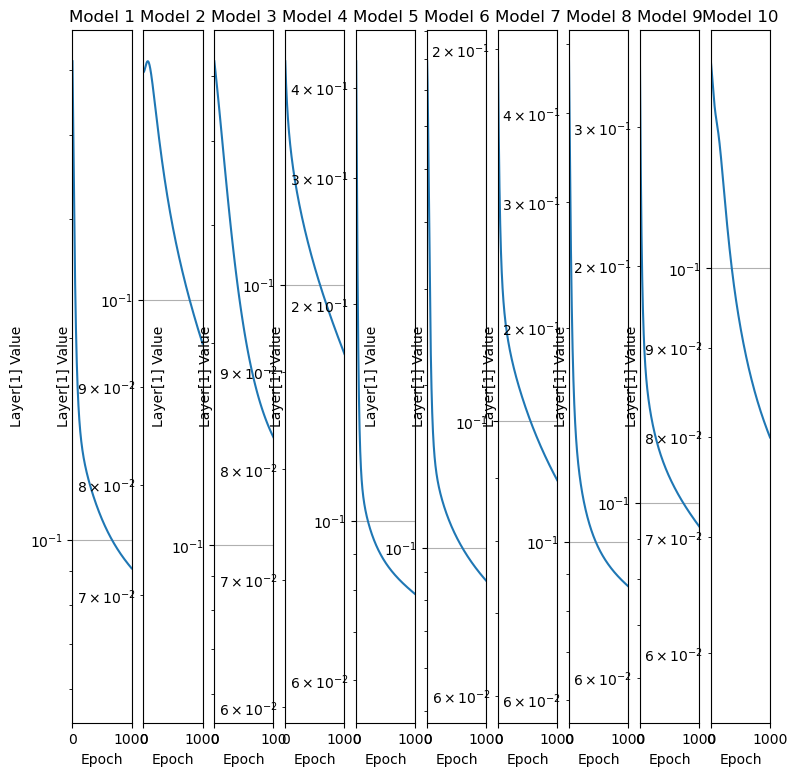

In [6]:

import matplotlib.pyplot as plt

# Extract the layer[1] values for each layer in layer_cost
layer1_values = [layer[1] for layer in layer_cost]
layer0_values = [layer[0] for layer in layer_cost]
for i in range(len(layer0_values)):
    print(f"Model {i+1} layer[1] layers and neurons: {layer0_values[i]}")
# Create a figure with subplots
fig, axs = plt.subplots(1, len(layer_cost), figsize=(9, 9))

# Plot the layer[1] values for each layer
for i, layer_values in enumerate(layer1_values):
    axs[i].plot(layer_values)
    axs[i].set_title(f"Model {i+1}")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Layer[1] Value")
    axs[i].grid(True)
    axs[i].set_yscale('log')
    axs[i].set_xlim(0, 1000) 
    
    
axs[2].set_xlim(0,100)# Set x-axis limits to zoom in on epoch 0-100
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
    

    



Threshold: 0.5
F1 score for y_test with W,b: 0.6936416184971098

Threshold: 0.6
F1 score for y_test with W,b: 0.5732484076433121

Threshold: 0.7
F1 score for y_test with W,b: 0.48275862068965514

Threshold: 0.8
F1 score for y_test with W,b: 0.34375000000000006

Threshold: 0.9
F1 score for y_test with W,b: 0.14035087719298248



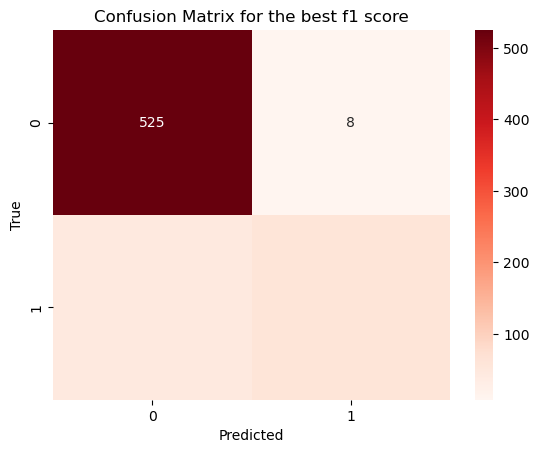

[[525   8]
 [ 45  60]]
Best threshold: 0.5


In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def predict(X,W,b,threshold):
    return forward_propagation(X,W,b)[-1]>threshold
best_threshold = -1
best_f1=-1
threshold_list = [0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in threshold_list:
    y_pred = predict(X_test, W_best, b_best, threshold)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Threshold: {threshold}")

    print(f"F1 score for y_test with W,b: {f1_score(y_test, y_pred)}")
    if f1_score(y_test, y_pred) > best_f1:
        best_f1 = f1_score(y_test, y_pred)
        best_threshold = threshold
        best_y_pred = y_pred
        best_cm = cm
    print()
# Assuming y_test is the true labels and y_pred is the predicted labels
# Calculate the confusion matrix


# Plot the confusion matrix using seaborn
sns.heatmap(best_cm, annot=True, cmap='Reds', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the best f1 score')
plt.show()
print(best_cm)
print(f"Best threshold: {best_threshold}")


In [8]:
# import tensorflow as tf

# # Define the neural network architecture
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])
# X_train = X_train.astype(np.float32)
# y_train = y_train.astype(np.float32)
# X_val = X_val.astype(np.float32)
# y_val = y_val.astype(np.float32)
# X_test = X_test.astype(np.float32)
# y_test = y_test.astype(np.float32)

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train, y_train, epochs=100, batch_size=32)

# def accuracy(y_true, y_pred, threshold=0.5):
#     return np.mean((y_pred > threshold) == y_true)

# # Evaluate the model on the validation set
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f'Validation loss: {loss}, accuracy: {accuracy}')
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test loss: {loss}, accuracy: {accuracy}')
# # Save the model
# # Assuming you have a test set named X_test

# model.save('model.h5')





In [9]:
# import tensorflow as tf
# model = tf.keras.models.load_model('model.h5')

# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test loss: {loss}, accuracy: {accuracy}')

# predictions = model.predict(X_test)

# print(predictions[predictions > 0.5])

In [10]:
# from sklearn.model_selection import train_test_split
# import numpy as np
# import pandas as pd


# df =pd.read_csv('test.csv')

# ### UNCOMMENT THIS PART TO USE THE FEATURE ENGINEERING
# df['total_call'] = df['total_day_calls'] + df['total_eve_calls'] + df['total_night_calls']

# # Create 'total_charges' feature
# df['total_charges'] = df['total_day_charge'] + df['total_eve_charge'] + df['total_night_charge']

# # Create 'total_minutes' feature
# df['total_minutes'] = df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes']
# df = df.drop(['total_day_calls', 'total_eve_calls', 'total_night_calls'], axis=1)

# # Delete contributing features for 'total_charges'
# df = df.drop(['total_day_charge', 'total_eve_charge', 'total_night_charge'], axis=1)

# # Delete contributing features for 'total_minutes'
# df = df.drop(['total_day_minutes', 'total_eve_minutes', 'total_night_minutes'], axis=1)


# df.drop(['state', 'area_code', 'account_length','id'], axis=1, inplace=True)


# ###################

# ###ONE HOT ENCODING
# #df = pd.get_dummies(df, columns=['area_code','state'])


# ### MOVING THE Y VARIABLE TO THE END


# data=np.array(df)


# data[data=='no']=0
# data[data=='yes']=1
# data[data==False]=0
# data[data==True]=1
# X=data
# def normalize(X):
#     X = X.astype(float)
#     X=(X-X.mean(axis=0))/X.std(axis=0)
#     return X
# X=normalize(X)


In [11]:

# # Preprocess the data
# X = X.astype(np.float32)
# import tensorflow as tf
# model = tf.keras.models.load_model('model.h5')

# # Evaluate the model on the test set


# predictions = model.predict(X)

# print(predictions[predictions > 0.5])